C:\Users\avnit\Anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
C:\Users\avnit\Anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


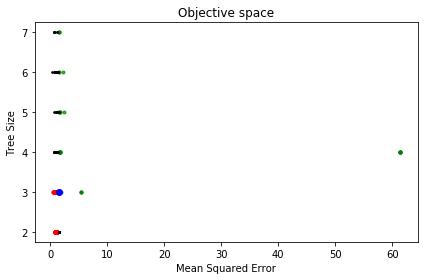

gen	nevals	avg                    	std                    	min                    	max                    
0  	50    	[1.10650195 3.26      ]	[0.30401178 1.45340978]	[0.72012608 2.        ]	[1.55251825 7.        ]
1  	66    	[0.84741287 3.94      ]	[0.20331581 1.62984662]	[0.62937003 1.        ]	[1.49062507 7.        ]
2  	74    	[0.73152614 4.26      ]	[0.03894396 1.43958327]	[0.62937003 2.        ]	[0.82078751 7.        ]
3  	65    	[0.70577647 4.54      ]	[0.06045703 1.68772036]	[0.49416153 2.        ]	[0.82078751 7.        ]
4  	66    	[0.688637 4.38    ]    	[0.06643464 1.58606431]	[0.49416153 3.        ]	[0.72234418 7.        ]
5  	67    	[0.66372842 4.72      ]	[0.07364579 1.51049661]	[0.49416153 2.        ]	[0.82078751 7.        ]
6  	71    	[0.60540029 5.        ]	[0.08975108 1.42828569]	[0.38911481 3.        ]	[0.72234418 8.        ]
7  	66    	[0.51068731 5.06      ]	[0.07762804 2.12988263]	[0.37082423 3.        ]	[0.72012608 9.        ]
8  	67    	[0.49007428 5.2       ]	[0

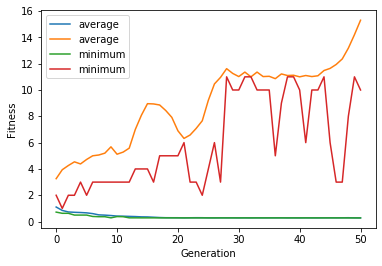

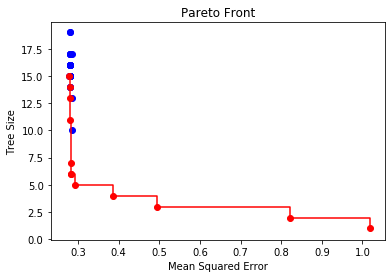

Area Under Curve: 2.3841416372199005


In [2]:
import random
import operator

import numpy as np
import matplotlib.pyplot as plt

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

#Create new fitness and individual classes
creator.create("FitnessMin", base.Fitness, weights=(-1.0,-1.0))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

#Want to minimize two objectives: mean squared error and tree size
#add new primitives + set seed for randomization
random.seed(25)

pset = gp.PrimitiveSet("MAIN", arity=1)
pset.addPrimitive(np.add, arity=2)
pset.addPrimitive(np.subtract, arity=2)
pset.addPrimitive(np.multiply, arity=2)
pset.addPrimitive(np.negative, arity=1)
pset.addPrimitive(np.sin, arity=1)
pset.addPrimitive(np.cos, arity=1)
pset.addPrimitive(np.tan, arity=1)
pset.renameArguments(ARG0='x')

toolbox = base.Toolbox()
#genHalfAndHalf creates expression with primitive set pset
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

#Add another objective and change problem
#reinitialize toolbox functions
def evalSymbReg(individual, points, pset):
    func = gp.compile(expr=individual, pset=pset)
    sqerrors = (func(points)-(np.negative(points) + np.sin(points**2) + np.tan(points**3) - np.cos(points)))**2

    return (np.sqrt(np.sum(sqerrors) / len(points)), len(individual))


toolbox.register("evaluate", evalSymbReg, points=np.linspace(-1, 1, 1000), pset=pset)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

#define pareto dominance function to help visualize objective space
#returns true if first individual dominates the second
def pareto_dominance(ind1, ind2):
    not_equal = False
    for value_1, value_2 in zip(ind1.fitness.values, ind2.fitness.values):
        if value_1 > value_2:
            return False
        elif value_1 < value_2:
            not_equal = True
    return not_equal

#initialize random population and individual for comparison
pop = toolbox.population(n=300)

fitnesses = list(map(toolbox.evaluate, pop))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

a_given_individual = toolbox.population(n=1)[0]
a_given_individual.fitness.values = toolbox.evaluate(a_given_individual)

#sort population by pareto dominance
dominated = [ind for ind in pop if pareto_dominance(a_given_individual, ind)]
dominators = [ind for ind in pop if pareto_dominance(ind, a_given_individual)]
others = [ind for ind in pop if not ind in dominated and not ind in dominators]

#plot objective space using sorted population
#blue - set aside and compare all individuals to
#black - uncomparable points
#green - dominated by given individual
for ind in dominators: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'r.', alpha=0.7)
for ind in dominated: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'g.', alpha=0.7)
for ind in others: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'k.', alpha=0.7, ms=3)
plt.plot(a_given_individual.fitness.values[0], a_given_individual.fitness.values[1], 'bo', ms=6);
plt.xlabel('Mean Squared Error');plt.ylabel('Tree Size');
plt.title('Objective space');
plt.tight_layout()
plt.show()

#define and run main evolutionary algorithm
NGEN = 50
MU = 50
LAMBDA = 100
CXPB = 0.5
MUTPB = 0.2

pop = toolbox.population(n=MU)
hof = tools.ParetoFront()
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0)
stats.register("std", np.std, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)

pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, MU, LAMBDA, CXPB, MUTPB, NGEN, stats,
                          halloffame=hof)

#Plot + print results
#orange + red = tree size
#blue + green = MSE
#Used Mu plus Lambda evolutionary algorithm - adds two new parameters
#mu - Number individuals to select for next generation
#lambda = number of children to produce
#size of primitive trees raise; mean squared error quickly drops
print("Best individual is: %s\nwith fitness: %s" % (hof[0], hof[0].fitness))
gen, avg, min_, max_ = logbook.select("gen", "avg", "min", "max")
plt.plot(gen, avg, label="average")
plt.plot(gen, min_, label="minimum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="upper left")
plt.show()

#visualize space and pareto front
"""Split fitness values into separate lists"""
fitness_1 = [ind.fitness.values[0] for ind in hof]
fitness_2 = [ind.fitness.values[1] for ind in hof]
pop_1 = [ind.fitness.values[0] for ind in pop]
pop_2 = [ind.fitness.values[1] for ind in pop]

'''Print dominated population for debugging'''
# for ind in pop:
#     print(ind.fitness)

plt.scatter(pop_1, pop_2, color='b')
plt.scatter(fitness_1, fitness_2, color='r')
plt.plot(fitness_1, fitness_2, color='r', drawstyle='steps-post')
plt.xlabel("Mean Squared Error")
plt.ylabel("Tree Size")
plt.title("Pareto Front")
plt.show()

f1 = np.array(fitness_1)
f2 = np.array(fitness_2)

"""Calculate area under curve with least squares method"""
print("Area Under Curve: %s" % (np.sum(np.abs(np.diff(f1))*f2[:-1])))

In [ ]:
#Strongly Typed Genetic Programming
#define primitive set with PrimitiveSetTyped() first: name of set
#second: define iput/leaf, third: output of individual tree
def if_then_else(input, output1, output2):
    return output1 if input else output2

pset = PrimitiveSetTyped("main", [bool, float], float)
pset.addPrimitive(operator.xor, [bool, bool], bool)
pset.addPrimitive(operator.mul, [float, float], float)
pset.addPrimitive(if_then_else, [bool, float, float], float)
pset.addTerminal(3.0, float)
pset.addTerminal(1, bool)

pset.renameArguments(ARG0="x")
pset.renameArguments(ARG1="y")

#ephemeral: terminals generated by a function
pset.addEphemeralConstant(lambda: random.randint(-10, 10), int)

#Bloat Control: Limit tree size; auto max depth: 91 due to limitations
